In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Importing dependencies
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import tensorflow as tf
plt.style.use('ggplot')

### Data Preprocessing

In [3]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

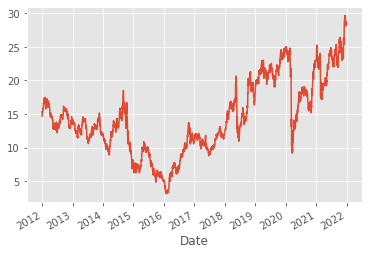

In [4]:
# Loading the dataset

df = yf.download(tickers='petr4.sa', start="2012-01-01", end="2021-12-31")
df.drop(df[df['Volume']==0].index, inplace = True)
df['Adj Close'].plot()

In [5]:
# Correlation matrix
df.corr()['Adj Close']

Open         0.977516
High         0.978948
Low          0.978031
Close        0.979554
Adj Close    1.000000
Volume       0.131513
Name: Adj Close, dtype: float64

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,21.510000,22.120001,21.260000,21.730000,14.724219,20391300
2012-01-03,21.830000,22.410000,21.809999,22.410000,15.309901,22940500
2012-01-04,22.180000,22.580000,21.980000,22.570000,15.419212,18736900
2012-01-05,22.389999,22.610001,22.150000,22.309999,15.241587,19489000
2012-01-06,22.469999,22.580000,22.250000,22.330000,15.255250,13941000
...,...,...,...,...,...,...
2021-12-23,28.330000,28.420000,28.150000,28.330000,28.330000,28713600
2021-12-27,28.320000,28.780001,28.150000,28.750000,28.750000,44227900
2021-12-28,29.010000,29.280001,28.700001,28.780001,28.780001,30688100


In [7]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df.shape

count    2.459000e+03
mean     5.310038e+07
std      3.564150e+07
min      3.248000e+05
25%      3.100710e+07
50%      4.627170e+07
75%      6.583375e+07
max      6.989506e+08
Name: Volume, dtype: float64


(2459, 6)

In [8]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [9]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [10]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    
    X_train,Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [11]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [12]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Preço normalizado')
    #plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [13]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

            Adj Close       Open        Low       High
Date                                                  
2012-01-02  14.724219  21.510000  21.260000  22.120001
2012-01-03  15.309901  21.830000  21.809999  22.410000
2012-01-04  15.419212  22.180000  21.980000  22.580000
2012-01-05  15.241587  22.389999  22.150000  22.610001
2012-01-06  15.255250  22.469999  22.250000  22.580000
...               ...        ...        ...        ...
2021-12-23  28.330000  28.330000  28.150000  28.420000
2021-12-27  28.750000  28.320000  28.150000  28.780001
2021-12-28  28.780001  29.010000  28.700001  29.280001
2021-12-29  28.540001  28.700001  28.420000  28.900000
2021-12-30  28.450001  28.549999  28.389999  28.700001

[2459 rows x 4 columns]


<AxesSubplot:xlabel='Date'>

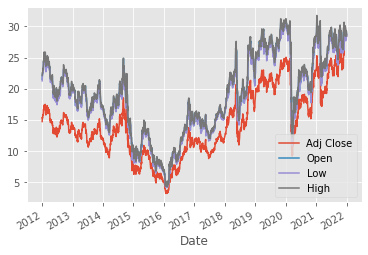

In [14]:
# Extracting the series
features = ['Adj Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series)
series.plot()

In [15]:
# Train Val Test Split
qt_teste = 300

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(1859, 4) (300, 4) (300, 4)


In [16]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1859, 4) (300, 4) (300, 4)


In [17]:
timesteps = 10
hl = [30,25]
lr = 1e-3
batch_size = 64
num_epochs = 100

Epoch 00100: early stopping


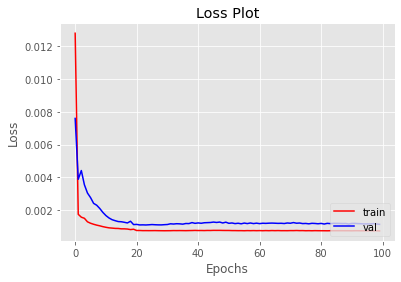

In [18]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.06631374213377779
MSE = 0.007400841646237986
RMSE = 0.08602814450072713
R2-Score = 0.6592432983456262


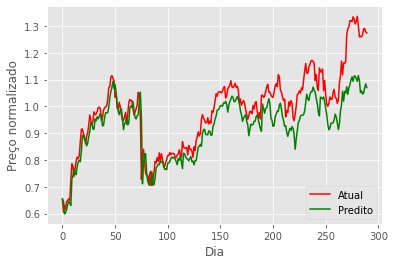

In [20]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
plot_data(true,predicted)

In [21]:
# Save a model
model.save('RNN-M PETR4')
del model  #Deletes the model
# Load a model
model = load_model('RNN-M PETR4')

INFO:tensorflow:Assets written to: RNN-M PETR4\assets


## Cross Validation

In [22]:
timesteps = 10
hl = [30,25]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [23]:
# Extracting the series
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2459, 4)
            Adj Close       Open        Low       High
Date                                                  
2021-12-23  28.330000  28.330000  28.150000  28.420000
2021-12-27  28.750000  28.320000  28.150000  28.780001
2021-12-28  28.780001  29.010000  28.700001  29.280001
2021-12-29  28.540001  28.700001  28.420000  28.900000
2021-12-30  28.450001  28.549999  28.389999  28.700001


In [24]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.43574494, 0.63499636, 0.6465485 , 0.64932705],
       [0.45782691, 0.64673516, 0.66729536, 0.65987631],
       [0.46194827, 0.6595745 , 0.67370804, 0.66606038],
       ...,
       [0.96569026, 0.91012476, 0.92719734, 0.90978539],
       [0.95664155, 0.89875281, 0.91663526, 0.89596215],
       [0.95324827, 0.89325019, 0.91550359, 0.88868682]])

### Split I

In [25]:
#Splitting the data for initial model creation
splits = 5
split_size = 300

cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()

Split 1
MAE = 0.023209232520462766
MSE = 0.001017916069014892
RMSE = 0.03190479695931149
R-Squared Score = 0.8927465859825335


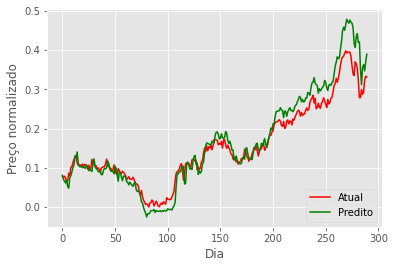

In [26]:
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
end = time.time()   

train_loss['Split1'] =  history.history['loss']
val_loss['Split1'] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split1.h5")

### Split II

Split 2
MAE = 0.05683172792232069
MSE = 0.003464291880696083
RMSE = 0.05885823545346974
R-Squared Score = -0.46950683452018405


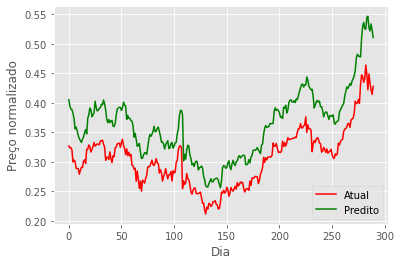

In [27]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split2.h5")

### Split III

Split 3
MAE = 0.09869757383723995
MSE = 0.01066251745163718
RMSE = 0.10325946664416381
R-Squared Score = 0.21566561306603083


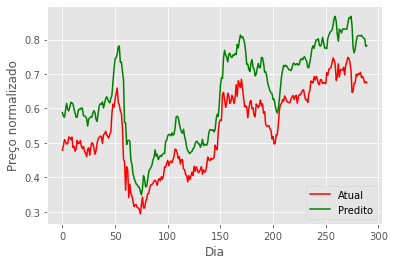

In [28]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split3.h5")

### Split IV

Split 4
MAE = 0.08075090174260775
MSE = 0.007686383680089513
RMSE = 0.08767202336030298
R-Squared Score = 0.6511102545921508


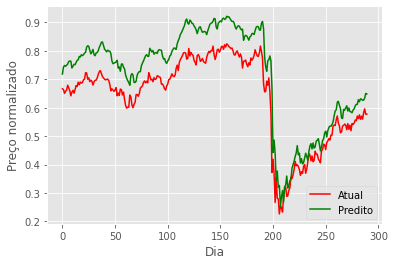

In [29]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split4.h5")

### Split V

Split 5
MAE = 0.08867696784241624
MSE = 0.008922582812907266
RMSE = 0.09445942416142111
R-Squared Score = 0.18462664652224325


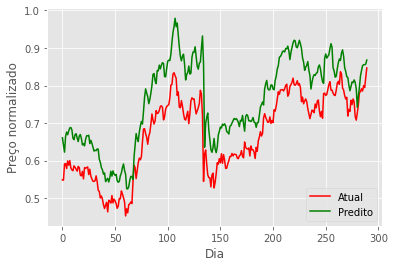

In [30]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]

X_train,Y_train = to_sequential_data(train, timesteps)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mae, mse,rmse,r2_value,end-start])
model.save("MV-RNN-Split5.h5")

In [31]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MAE = {}".format(CV_temp['MAE'].mean()))
print("Avg. MSE = {}".format(CV_temp['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_temp['R2_Score'].mean()))
cross_val_results.append([CV_temp['MAE'].mean(), CV_temp['MSE'].mean(),CV_temp['RMSE'].mean(),CV_temp['R2_Score'].mean()])
cross_val_results.append([CV_temp['MAE'].std(), CV_temp['MSE'].std(),CV_temp['RMSE'].std(),CV_temp['R2_Score'].std()])
CV_results = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score', 'Train_Time'])

Avg. MAE = 0.06963328077300948
Avg. MSE = 0.006350738378868986
Avg. RMSE = 0.07523078931573382
Avg. R2-score = 0.29492845312855487


In [32]:
CV_results.to_csv('RNN-M PETR4.csv')
# train_loss.to_csv('MV3-GRU_CrossValidation_TrainLoss.csv')
# val_loss.to_csv('MV3-GRU_CrossValidation_ValLoss.csv')